# RAPIDS & Scanpy Single-Cell RNA-seq Multi-GPU Workflow on 1 Million Cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1M brain cells with Unified Virtual Memory to oversubscribe GPU memory. We then use dask to scale PCA, K-means clustering, and UMAP across multiple GPUs.

See the README for instructions to download this dataset.

## Import requirements

In [1]:
import time
import pandas as pd
import numpy as np
import scanpy as sc
import anndata

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from natsort import natsorted

import cupy as cp
import cupyx as cpx
import cupyx
import cugraph

import cudf
import math

import h5py
import scipy

import dask
import dask_cudf
import rmm

from dask_cuda import initialize, LocalCUDACluster
from dask import delayed, dataframe
from dask.dataframe.utils import make_meta
from dask.distributed import Client, default_client
from dask_cuda.local_cuda_cluster import cuda_visible_devices
import dask.dataframe as dd

from cuml.manifold import TSNE, UMAP
from cuml.linear_model import LinearRegression

from cuml.dask.decomposition import PCA as cu_dask_PCA
from cuml.dask.cluster import KMeans as cu_dask_KMeans
from cuml.dask.manifold import UMAP as cu_dask_UMAP
from cuml.dask.linear_model import LinearRegression as cu_dask_LinearRegression
from cuml.dask.neighbors import NearestNeighbors as cu_dask_NearestNeighbors

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')


We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory

In [2]:
cluster_start = time.time()

enable_tcp_over_ucx = True
enable_nvlink = True
enable_infiniband = True
CUDA_VISIBLE_DEVICES = cuda_visible_devices(0).split(',')
# CUDA_VISIBLE_DEVICES = [1, 2, 3, 4, 5, 6, 7]
CUDA_VISIBLE_DEVICES = [0, 1]

rmm.reinitialize(managed_memory=False)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

initialize.initialize(create_cuda_context=True,
                      enable_tcp_over_ucx=enable_tcp_over_ucx,
                      enable_nvlink=enable_nvlink,
                      enable_infiniband=enable_infiniband)

cluster = LocalCUDACluster(protocol="ucx",
                           dashboard_address=':9001',
                           CUDA_VISIBLE_DEVICES=CUDA_VISIBLE_DEVICES,
                           enable_tcp_over_ucx=enable_tcp_over_ucx,
                           enable_nvlink=enable_nvlink,
                           enable_infiniband=enable_infiniband)

client = Client(cluster)
client.run(cp.cuda.set_allocator)
n_workers = len(client.scheduler_info()['workers'].keys())
client

Client Scheduler: ucx://127.0.0.1:45068 Dashboard: http://127.0.0.1:9001/status,Cluster Workers: 2 Cores: 2 Memory: 33.58 GB


## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [3]:
import os, wget

input_file = "../data/1M_brain_cells_10X.sparse.h5ad"
if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download(
        'https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
        input_file)

## Set parameters

In [4]:
# marker genes
MITO_GENE_PREFIX = "mt-"              # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"]  # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200      # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000     # Filter out cells with more genes than this expressed 
min_cells=1                   # Genes containing a number of cells below this value will be filtered

# filtering genesinitialize
n_top_genes = 4000            # Number of highly variable genes to retain

# PCA
n_components = 50             # Number of principal components to compute
pca_train_ratio = 0.35        # percentage of cells to use for PCA training
n_pca_batches = 10

# t-SNE
tsne_n_pcs = 20               # Number of principal components to use for t-SNE

# k-means
k = 35                        # Number of clusters for k-means

# KNN
n_neighbors = 15              # Number of nearest neighbors for KNN graph
knn_n_pcs = 50                # Number of principal components to use for finding nearest neighbors

# UMAP
umap_train_ratio = 0.35
umap_min_dist = 0.3
umap_spread = 1.0

max_cells = 100000           # To filter first x numbers of rows. Please change it to -1 for using all
BATCHSIZE = 20000

start_time = time.time()

## Load and Prepare Data

## We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [5]:
data_load_time = time.time()

In [6]:
%%time

with h5py.File(input_file, 'r') as h5f:
    indptr = h5f['/X/indptr']
    orginal_genes = cudf.Series(h5f['/var/_index'], dtype=cp.dtype('object'))
    total_cols = orginal_genes.shape[0]
    total_rows = indptr.shape[0] - 1

if max_cells <= 0:
    max_cells = total_rows

def partition_postprocessor_sum(partial_sparse_array):
    partial_sparse_sq_array = partial_sparse_array.power(2)
    col1 = partial_sparse_array.sum(axis=0)
    col2 = partial_sparse_sq_array.sum(axis=0)
    ret_value = cp.hstack([col1, col2])

    del partial_sparse_sq_array

    return ret_value
    
print('Computing data required to create filter...')
aggregated_mat = utils.read_to_sparse_matrix(input_file,
                                       max_cells, BATCHSIZE, total_cols * 2,
                                       None, partition_postprocessor_sum,
                                       min_genes_per_cell=min_genes_per_cell,
                                       max_genes_per_cell=max_genes_per_cell)
aggregated_mat = aggregated_mat.compute()

# Split the sum and square
sum_mat = aggregated_mat[:, 0:aggregated_mat.shape[1]/2].sum(axis=0)
sum_sq_mat = aggregated_mat[:, aggregated_mat.shape[1]/2:]

# Filter genes with at-least <<min_cells>> number of cells rec.
min_cell_filter = (sum_mat >= min_cells)

sum_mat = sum_mat[min_cell_filter]
sum_sq_mat = sum_sq_mat[:, min_cell_filter].sum(axis=0)
genes = orginal_genes[min_cell_filter]

del aggregated_mat

print('Loading data into dataframes...')
sparse_dask_array = utils.read_to_sparse_matrix(input_file,
                                       max_cells, BATCHSIZE, sum_sq_mat.shape[0],
                                       min_cell_filter, None,
                                       min_genes_per_cell=min_genes_per_cell,
                                       max_genes_per_cell=max_genes_per_cell)

sparse_dask_array = sparse_dask_array.persist()
sparse_dask_array

Computing data required to create filter...
Loading data into dataframes...
CPU times: user 7.94 s, sys: 1.07 s, total: 9.02 s
Wall time: 34 s


dask.array<concatenate, shape=(100000, 21517), dtype=float32, chunksize=(20000, 21517), chunktype=numpy.ndarray>

For this example, we select the first 1 million cells in the dataset. We maintain the index of unique genes in our dataset:

Verify the shape of the resulting sparse matrix:

In [7]:
%%time
sparse_dask_array = dask.array.log1p(sparse_dask_array)

CPU times: user 1.45 ms, sys: 0 ns, total: 1.45 ms
Wall time: 1.47 ms


And the number of non-zero values in the matrix:

In [8]:
data_load_time = time.time() - data_load_time
print("Total data load and Filtering: %s" % data_load_time)

Total data load and Filtering: 34.03689241409302


## Preprocessing

In [9]:
preprocess_time = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

Some genes will now have zero expression in all cells. We filter out such genes.

In [10]:
%%time
# FILTERING IS NOT DONE WHILE READING DATA
# sparse_dask_array, genes = rapids_scanpy_funcs.filter_genes(sparse_dask_array, genes.get(), min_cells=1)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs


The size of our count matrix is now reduced.

In [11]:
%%time
sparse_dask_array.shape

CPU times: user 19 µs, sys: 4 µs, total: 23 µs
Wall time: 27.2 µs


(100000, 21517)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [12]:
%%time
# This is now done while loading data
# sparse_dask_array = rapids_scanpy_funcs.normalize_total(sparse_dask_array, target_sum=1e4)

# sparse_dask_array = sparse_dask_array.astype(cp.float32)
# sparse_dask_array.shape

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs


Next, we log transform the count matrix.

In [13]:
%%time

marker_genes_raw = {}
genes = genes.reset_index(drop=True)
i = 0
for index in genes[genes.isin(markers)].index.to_arrow().to_pylist():
    marker_genes_raw[markers[i]] = sparse_dask_array[:, index].compute().toarray().ravel()
    i += 1

CPU times: user 1.73 s, sys: 131 ms, total: 1.86 s
Wall time: 10.8 s


### Select Most Variable Genes

We convert the count matrix to an annData object.

Before filtering the count matrix, we save the 'raw' expression values of the marker genes to use for labeling cells afterward.

Using scanpy, we filter the count matrix to retain only the most variable genes.

In [14]:
time_marker_highly_variable = time.time()

In [15]:
%%time
# gpu_array = sparse_dask_array.compute()
# adata = anndata.AnnData(gpu_array.get())
# adata.var_names = genes.to_pandas()

# sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")
# sc_hightly_variable = genes[adata.var.highly_variable.values]

vaiable_genes = utils.highly_variable_genes_filter(sum_mat, 
                                                   sum_sq_mat, 
                                                   sparse_dask_array, 
                                                   genes, 
                                                   n_top_genes=n_top_genes)
genes = genes[vaiable_genes]

# Filter highly variable genes
dask_array = sparse_dask_array[:, vaiable_genes]
del sum_sq_mat, sum_mat

CPU times: user 1.55 s, sys: 29.6 ms, total: 1.58 s
Wall time: 1.52 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [16]:
%%time
time_regress_out = time.time()

sparse_dask_array = utils.csr_to_csc(dask_array, client=client)
sparse_dask_array = sparse_dask_array.persist()
del dask_array

CPU times: user 959 ms, sys: 232 ms, total: 1.19 s
Wall time: 2.63 s


In [17]:
%%time

mito_genes = genes.str.startswith(MITO_GENE_PREFIX)
mito_genes = cp.fromDlpack(mito_genes.to_dlpack())
mito_genes_indices = cp.where(mito_genes == 1)[0]

n_counts = utils.sum_csc(sparse_dask_array, client=client)
n_counts = dask.array.sum(n_counts, axis=1).compute()

result = dask.array.take(sparse_dask_array,
                         mito_genes_indices.tolist(),
                         axis=1)
result = utils.sum_csc(result, client=client)
result = dask.array.sum(result, axis=1)
result = dask.array.true_divide(result, n_counts)
# result.compute()

percent_mito = dask.array.ravel(result)
percent_mito = percent_mito.compute()
del result, genes, mito_genes

CPU times: user 539 ms, sys: 23.1 ms, total: 562 ms
Wall time: 1.5 s


And perform regression:

In [18]:
%%time
regressors = cp.ones((n_counts.shape[0]*3), dtype=cp.float32).reshape((n_counts.shape[0], 3), order="F")
regressors[:, 1] = n_counts
regressors[:, 2] = percent_mito

X = dask.array.from_array(regressors, asarray=False)
del regressors
del n_counts
X.shape

CPU times: user 0 ns, sys: 2.96 ms, total: 2.96 ms
Wall time: 1.8 ms


(99109, 3)

In [19]:
%%time

# sparse_gpu_array = rapids_scanpy_funcs.regress_out(
#     sparse_gpu_array, n_counts, percent_mito)

def regress(regressors, arr, cols_per_task=10):
    
    @delayed
    def _regress(X, data):
        if hasattr(data, 'todense'):
            data = data.todense()

        outputs = cp.empty(data.shape, dtype=data.dtype, order="F")
        for i in range(data.shape[1]):
            y = data[:, i]
            lr = LinearRegression(fit_intercept=False, output_type="cupy")
            lr.fit(X, y, convert_dtype=True)
            outputs[:, i] = y.reshape(y.shape[0], ) - lr.predict(X).reshape(y.shape[0])
        del data
        return outputs

    print('Creating dask tasks for LinearRegression...')
    ld_delay = []

    for i in range(0, arr.shape[1], cols_per_task):
        y = arr[:, i:i+cols_per_task]
        ld_delay.append(
            dask.array.from_delayed(
                (_regress)(regressors, y),
                dtype=cp.float32,
                shape=(arr.shape[0], cols_per_task)))
        del y

    print('Computing...')
    result = dask.array.concatenate(ld_delay, axis=1)
    return result

sparse_dask_array = regress(X, sparse_dask_array, cols_per_task=20)
sparse_dask_array

Creating dask tasks for LinearRegression...
Computing...
CPU times: user 121 ms, sys: 5.34 ms, total: 127 ms
Wall time: 121 ms


dask.array<concatenate, shape=(99109, 4000), dtype=float32, chunksize=(99109, 20), chunktype=numpy.ndarray>

### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [20]:
%%time
# sparse_gpu_array = rapids_scanpy_funcs.scale(sparse_gpu_array, max_value=10)

max_value=10

def scale(dask_array, client, max_value=10):
    mean = dask.array.mean(dask_array, axis=0)
    temp_array = dask.array.subtract(dask_array, mean)

    stddev = dask.array.sqrt(mean.var())
    temp_array = dask.array.true_divide(temp_array, stddev)
    dask_array = utils.clip(temp_array, client, max_value)

    del stddev
    del temp_array
    del mean
    
    return dask_array

sparse_dask_array = scale(sparse_dask_array, client, max_value=max_value)

CPU times: user 11.5 s, sys: 2.36 s, total: 13.9 s
Wall time: 1min


In [21]:
time_regress_out = time.time() - time_regress_out
print("Regressout and scale: %s" % time_regress_out)

preprocess_time = time.time() - preprocess_time
print("Total Preprocessing time: %s" % (preprocess_time))

Regressout and scale: 64.49452018737793
Total Preprocessing time: 76.8921594619751


## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [22]:
analysis_time = time.time()
sparse_dask_array[:,1].compute()

array([ 1.033065  ,  1.8888552 ,  1.3887058 , ...,  3.8059049 ,
       -2.291225  ,  0.34304392], dtype=float32)

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components. Here, we use Dask to parallelize across multiple GPUs.

The PCA multi-GPU time includes initial data transfer, which is about 20gb. 

In [30]:
%%time

# dask_df = dask.dataframe.from_array(sparse_gpu_array, columns=gene.to_arrow().to_pylist())
# dask_cu_df = dask_cudf.from_dask_dataframe(dask_df)
#
# The above line does not work due to worker failure while converting sparse
# array to dataframes. Folloiwng code is a workaround for loading data using 
# delayed functions.

def pca(dask_array, n_components, client, n_workers):
    dask_cu_df = utils.sparse_array_to_df(dask_array, n_workers)

    pca_model = cu_dask_PCA(n_components=n_components, client=client)
    dask_reduced_df = pca_model.fit_transform(dask_cu_df)

    reduced_df = dask_reduced_df.compute()
    return pca_model, dask_cu_df, reduced_df

pca_model, dask_cu_df, reduced_df = pca(sparse_dask_array, n_components, client, n_workers)
# reduced_df = reduced_df.reindex(range(reduced_df.shape[0]))
reduced_df = reduced_df.reset_index(drop=True)
print(reduced_df.shape)

Number of records is 99109 and batch size is 49555
Creating dask df from delays...
Creating Dataframe from futures...
(99109, 50)
CPU times: user 5.77 s, sys: 364 ms, total: 6.14 s
Wall time: 23.9 s


### t-SNE + k-Means

We cluster the cells using k-means on the principal components. For example purposes, we set k=35.

In [ ]:
%%time
tsne = TSNE().fit_transform(reduced_df.iloc[:, :tsne_n_pcs])

In [ ]:
%%time

def compute_kmeans(reduced_df, n_clusters):
    dask_array = dask_cudf.from_cudf(reduced_df, npartitions=n_workers*10)
    dask_kmeans = cu_dask_KMeans(n_clusters=n_clusters)
    dask_kmeans.fit(dask_array)
    labels = dask_kmeans.predict(dask_array).compute()
    labels.index = reduced_df.index
    return labels

tsne['kmeans'] = compute_kmeans(reduced_df, n_clusters=k)

tsne.head()

We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

In [ ]:
%%time
utils.show_scatter(tsne, 0, 1, 'kmeans', 'kmeans')

# sc.pl.tsne(adata, color=["kmeans"])
# x_embedded = TSNE().fit_transform(sparse_gpu_array)

We label the cells using the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively. These visualizations show us the separation of neuronal and glial cells on the t-SNE plot.

In [24]:
%%time

for marker_gene in marker_genes_raw:
    tsne[marker_gene + '_raw'] = marker_genes_raw[marker_gene]

utils.show_scatter_grad(tsne, 0, 1, 'Stmn2_raw', 'Stmn2')
utils.show_scatter_grad(tsne, 0, 1, 'Hes1_raw', 'Hes1')

del tsne, reduced_df
# sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
# sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

NameError: name 'tsne' is not defined

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

The UMAP function from Rapids is also integrated into Scanpy.

Finally, we use the Louvain algorithm for graph-based clustering, once again using the `rapids` option in Scanpy.

In [31]:
%%time
# sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
# sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
def compute_umap(sparse_dask_array, 
                 max_cells, 
                 dask_cu_df,
                 train_ratio=0.35, 
                 min_dist=umap_min_dist,
                 spread=umap_spread,
                 local_connectivity=1.0):
    tranining_data = sparse_dask_array[:int(max_cells * umap_train_ratio)].compute()
    local_model = UMAP(n_epochs=1000, min_dist=umap_min_dist, spread=umap_spread, local_connectivity=1.0)
    local_model.fit(tranining_data)

    dist_model = cu_dask_UMAP(local_model,
                              min_dist=umap_min_dist,
                              spread=umap_spread,
                              local_connectivity=1.0)
    return dist_model.transform(dask_cu_df)

X_umap = compute_umap(sparse_dask_array, 
                      max_cells, 
                      dask_cu_df,
                      train_ratio=umap_train_ratio, 
                      min_dist=umap_min_dist,
                      spread=umap_spread,
                      local_connectivity=1.0)

CPU times: user 5.09 s, sys: 2.56 s, total: 7.65 s
Wall time: 14.7 s


In [32]:
print(dask_cu_df.shape)
dask_cu_df.head()

(Delayed('int-519af33d-266b-47de-b234-a2dcf5621cda'), 4000)


,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,-0.134601,1.033065,-0.007802,-0.004683,-0.106764,-0.001184,-0.412280,1.683358,-0.212249,0.673192,...,0.416392,-34.683865,-33.483967,-2.563985,-22.395504,-2.174793,-27.393749,-0.003901,-0.004806,-3.183786
1,-0.242760,1.888855,-0.014233,-0.008532,-0.191244,-0.002157,-0.750381,3.111942,-0.385518,1.236789,...,0.511169,-63.371830,-61.258728,-4.611331,-40.969315,-3.642969,-50.144207,-0.007107,-0.008658,-6.005939
2,-0.179256,1.388706,-0.010477,-0.006274,-0.141539,-0.001589,-0.552813,2.276498,-0.284003,0.907420,...,0.375801,-46.603275,-45.128769,-3.392178,-30.374496,-2.847474,-36.907005,-0.005239,-0.006393,-4.441117
3,-0.035456,0.249708,-0.001916,-0.001155,-0.029274,-0.000294,0.072104,0.550343,-0.053525,0.157305,...,0.040392,-8.465184,-8.138768,-0.434590,-5.451695,-0.444571,-6.642628,-0.000970,-0.001274,-0.647461
4,0.263691,-2.114594,0.015849,0.009488,0.204504,0.002393,0.831234,-3.422220,0.425456,-1.399734,...,-0.634245,10.000000,10.000000,5.099449,10.000000,4.162724,10.000000,0.007880,0.009383,6.636578


In [33]:
%%time
def nearest_neighbors(dask_cu_df, client):
    nn = cu_dask_NearestNeighbors(client=client)
    nn.fit(dask_cu_df)
    dask_indices = nn.kneighbors(dask_cu_df, return_distance=False)

    # TODO: kneighbors is not setting dask metadata, therefore dask 
    # is not able to convert df to array.
    # dask_indices = dask_indices.to_records()
    # dask_indices = dask.array.ravel(dask_indices)

    indices = dask_indices.compute()
    indices = cp.array(indices.as_gpu_matrix())
    indices = cp.ravel(cp.asarray(indices))
    n_nonzero = indices.shape[0] * dask_indices.shape[1]
    indptr = cp.arange(0, indices.shape[0] + 1, dask_indices.shape[1])
    del nn, dask_indices
    return indices, indptr
    
indices, indptr = nearest_neighbors(dask_cu_df, client)

CPU times: user 2.94 s, sys: 178 ms, total: 3.12 s
Wall time: 14.9 s


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

In [34]:
%%time
# sc.tl.louvain(adata, flavor='rapids')
def louvain(indices, indptr, X_umap):
    offsets = cudf.Series(indptr)
    indices = cudf.Series(indices)
    g = cugraph.Graph()

    if hasattr(g, 'add_adj_list'):
        g.add_adj_list(offsets, indices, None)
    else:
        g.from_cudf_adjlist(offsets, indices, None)

    louvain_parts, _ = cugraph.louvain(g)

    groups = louvain_parts.sort_values('vertex')['partition']
    print(type(groups))
    groups = cp.fromDlpack(groups.to_dlpack())

    louvain_df = X_umap.compute()
    louvain_df = louvain_df.reindex(index=range(louvain_df.shape[0]))
    louvain_df['louvain_group'] = cudf.Series(groups)

    return louvain_df, g

umap_df, g = louvain(indices, indptr, X_umap)

<class 'cudf.core.series.Series'>
CPU times: user 1.66 s, sys: 3.61 s, total: 5.27 s
Wall time: 11.1 s


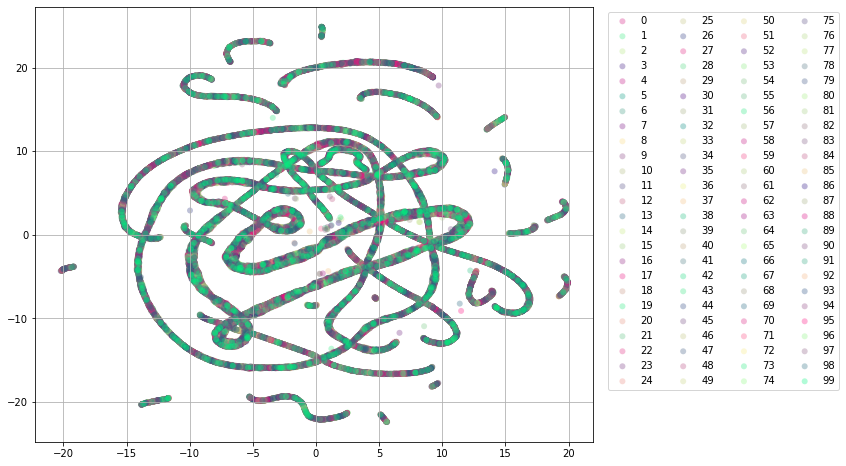

CPU times: user 16.3 s, sys: 919 ms, total: 17.2 s
Wall time: 16.1 s


In [38]:
%%time
    
# sc.pl.umap(adata, color=["louvain"])
utils.show_scatter(umap_df, 0, 1, 'louvain_group', 'louvain')

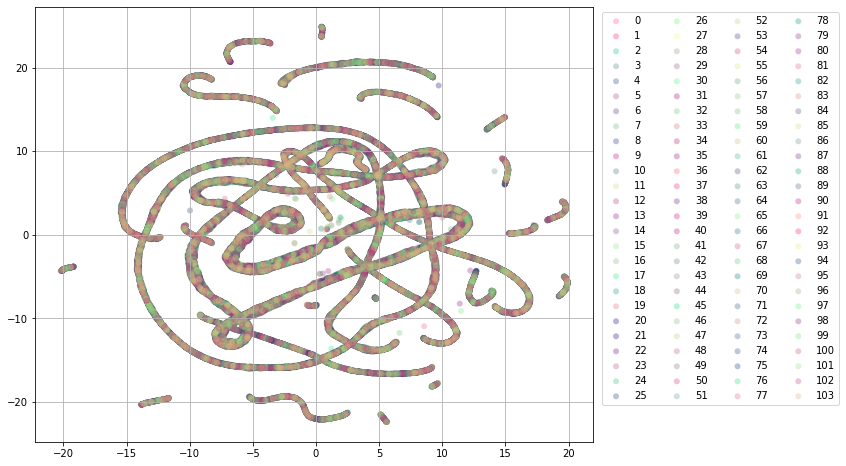

CPU times: user 16.9 s, sys: 820 ms, total: 17.7 s
Wall time: 16.7 s


In [36]:
%%time
# adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

leiden_parts, _ = cugraph.leiden(g)

groups = leiden_parts.sort_values('vertex')['partition']
groups = cp.fromDlpack(groups.to_dlpack())
umap_df['leiden_group'] = cudf.Series(groups)

utils.show_scatter(umap_df, 0, 1, 'leiden_group', 'leiden')

And also visualize the cells labeled by expression of the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively.

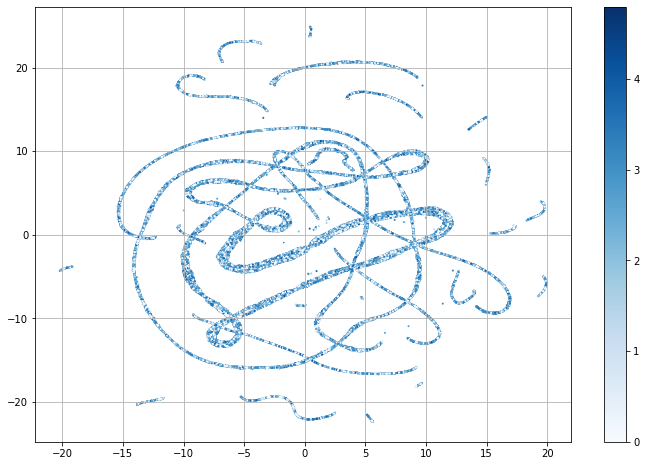

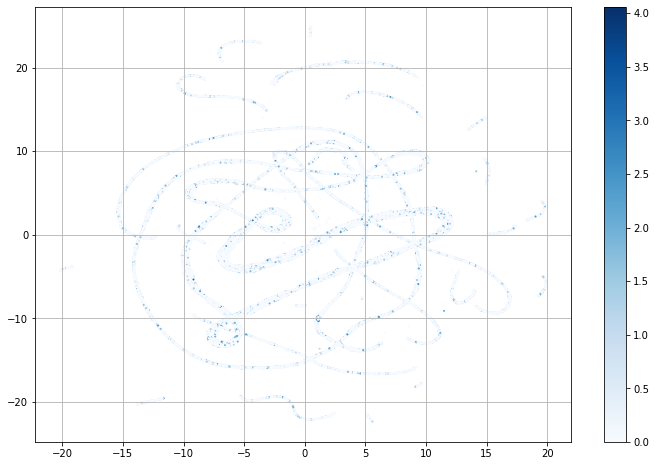

CPU times: user 3.63 s, sys: 1 s, total: 4.63 s
Wall time: 3.34 s


In [56]:
%%time
# sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
# sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)
    
for marker_gene in marker_genes_raw:
    umap_df[marker_gene + '_raw'] = marker_genes_raw[marker_gene]

utils.show_scatter_grad(umap_df, 0, 1, 'Stmn2_raw', 'Stmn2')
utils.show_scatter_grad(umap_df, 0, 1, 'Hes1_raw', 'Hes1')

In [ ]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

analysis_time = time.time() - analysis_time
print("Total analysis time: %s" % (analysis_time))

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select glial cells (Hes1+) from the dataset.

In [ ]:
reanalysis_time = time.time()

In [ ]:
%%time
hes1_cells = marker_genes_raw["Hes1"] > 0.0
hes1_data = sparse_dask_array[hes1_cells.get(), :]

We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds. 

Finally, we visualize the selected neuronal cells labeled by their new clusters, and by the expression of `Olig1`, a marker gene for oligodendrocytes.

In [ ]:
%%time
X_pca = pca(hes1_data, n_components, client, n_workers)

In [ ]:
# hes1_data = hes1_data.rechunk()
X_umap = compute_umap(hes1_data, 
                 max_cells, 
                 train_ratio=umap_train_ratio, 
                 min_dist=umap_min_dist,
                 spread=umap_spread,
                 local_connectivity=1.0)

In [ ]:
indices, indptr = nearest_neighbors(X_umap, client)

In [ ]:
louvain_df = louvain(indices, indptr, X_umap)

In [ ]:
utils.show_scatter(louvain_df, 0, 1, 'louvain_group', 'louvain')
utils.show_scatter_grad(louvain_df, 0, 1, 'Olig1_raw', 'Olig1_raw')

In [ ]:
%%time
# sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
# sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
# sc.tl.louvain(adata, flavor='rapids')

In [ ]:
%%time
# sc.pl.umap(adata, color=["louvain"])
# sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [ ]:
reanalysis_time = time.time() - reanalysis_time
print("Total reanalysis time : %s" % (reanalysis_time))

In [ ]:
print("# of cells         : %d" % max_cells)
print("Dataload time      : %s" % data_load_time)
print("Proprocessing time : %s" % preprocess_time)
print("Analysis time      : %s" % analysis_time)
# print("Reanalysis time    : %s" % reanalysis_time)

print("Full time: %s" % (time.time() - start_time))
# client.close()